In [2]:
from dataloader.dataloader import DatasetLoader

from functions.calculate_mse_psnr import calculate_mse_psnr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import copy
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau


from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

import os
import scipy.io
from tqdm import tqdm
from models.Restore import Restore

In [3]:
wts = "./train_results/Restore/1000_0.001_1000_0.8/best_model.pth"
device = "cpu"

model = Restore().to(device)
model.load_state_dict(torch.load(wts))
model.eval()
print("Model Ready")

Model Ready


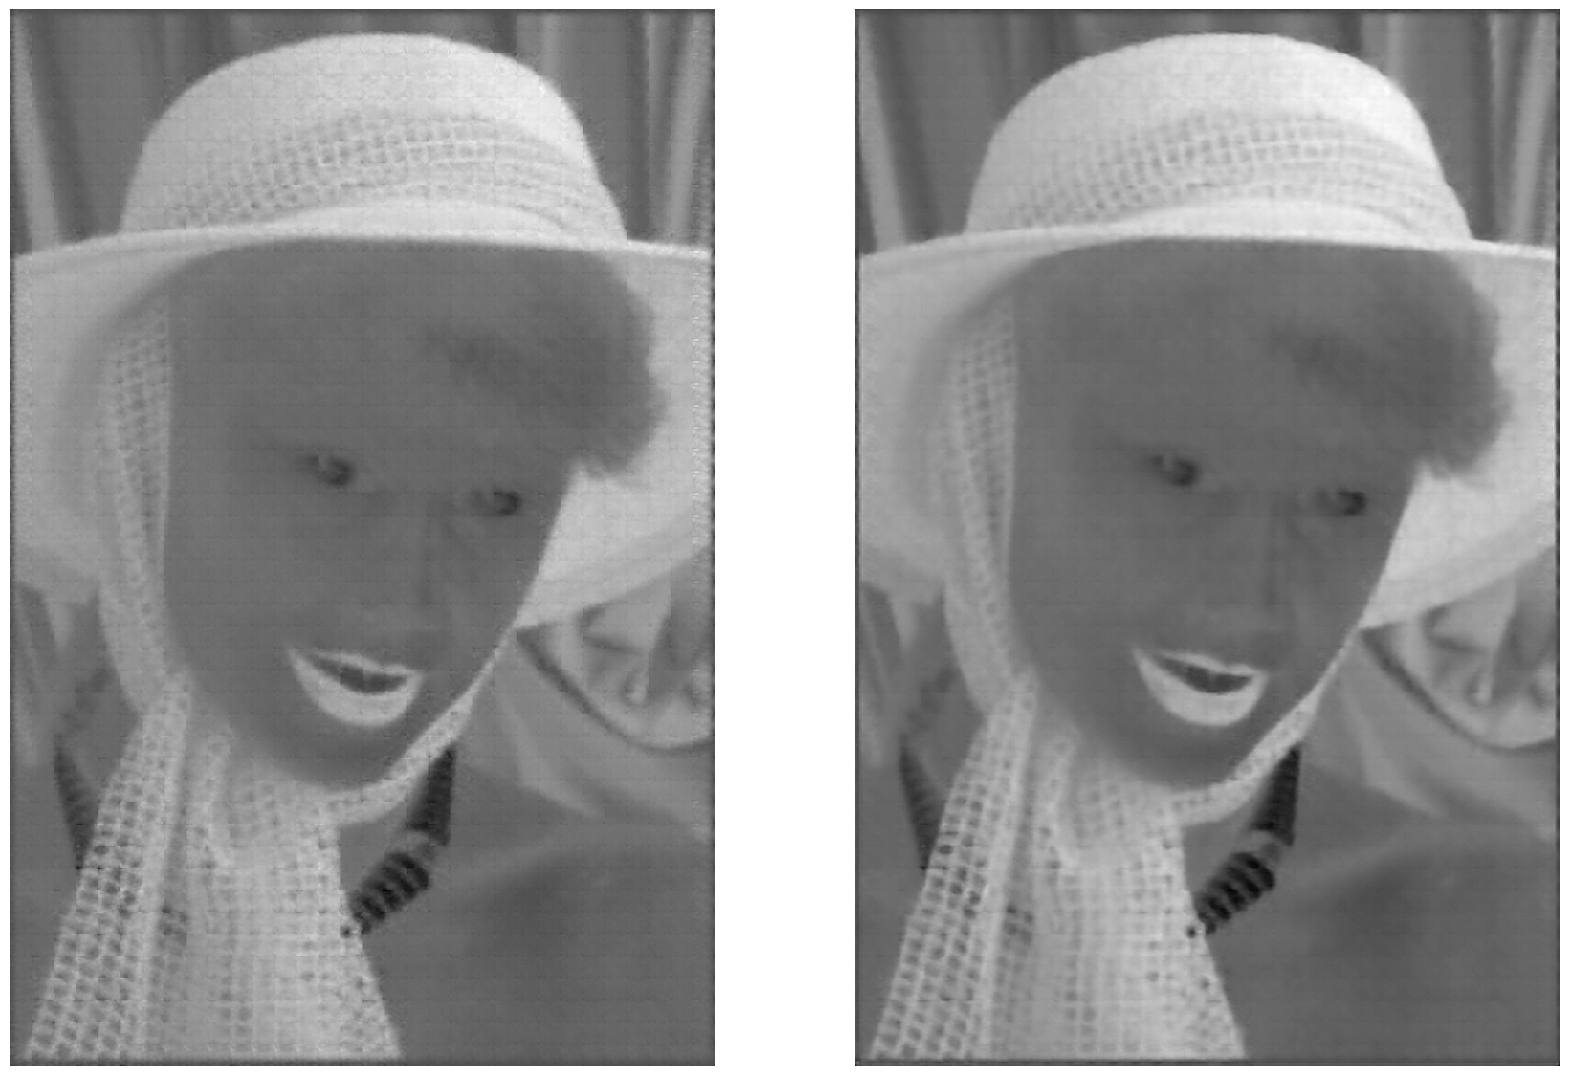

ValueError: operands could not be broadcast together with shapes (768,512) (512,512) 

In [9]:
transform = transforms.Compose([ # Ajusta al tamaño deseado
    transforms.ToTensor()
])

n = 18


image_to_restore = Image.open(f"./Cr.png").convert("L")
image_to_restoret = transform(image_to_restore)

imageOG = Image.open(f"dataset/standard_Images/Lenna.png").convert("L")

with torch.no_grad():
    image_restored = (model(image_to_restoret).cpu().squeeze())
image_restored = np.array(torch.clamp(image_restored, min=0, max=1))
image_restored = Image.fromarray((image_restored*255).astype(np.uint8))

plt.figure(figsize=(20, 20))

plt.subplot(1,2,1)
plt.imshow(image_to_restore, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image_restored, cmap='gray')
plt.axis("off")
plt.show()

mse, psnr = calculate_mse_psnr(image_restored,imageOG)
print(f"MSE : {mse} | PSNR : {psnr}")

In [10]:
image_restored.save('Cr.png')

In [1]:
from PIL import Image
import os

def dividir_imagenes_bn(carpeta_entrada, carpeta_salida, tamano_parche=(16, 16)):
    # Crear la carpeta de salida si no existe
    if not os.path.exists(carpeta_salida):
        os.makedirs(carpeta_salida)

    # Recorrer todos los archivos en la carpeta de entrada
    for archivo in os.listdir(carpeta_entrada):
        ruta_archivo = os.path.join(carpeta_entrada, archivo)
        
        # Verificar si el archivo es una imagen
        if os.path.isfile(ruta_archivo) and archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            imagen = Image.open(ruta_archivo).convert('L')  # Convertir a escala de grises
            ancho, alto = imagen.size

            # Calcular cuántos parches se pueden obtener en cada dimensión
            num_parches_x = ancho // tamano_parche[0]
            num_parches_y = alto // tamano_parche[1]

            # Dividir la imagen en parches y guardar cada uno
            contador = 1
            for y in range(num_parches_y):
                for x in range(num_parches_x):
                    # Definir la región del parche
                    inicio_x = x * tamano_parche[0]
                    inicio_y = y * tamano_parche[1]
                    fin_x = inicio_x + tamano_parche[0]
                    fin_y = inicio_y + tamano_parche[1]
                    parche = imagen.crop((inicio_x, inicio_y, fin_x, fin_y))

                    # Guardar el parche en formato PNG
                    nombre_parche = f"{archivo.split('.')[0]}parche{contador}.png"
                    ruta_parche = os.path.join(carpeta_salida, nombre_parche)
                    parche.save(ruta_parche, 'PNG')
                    contador += 1

# Uso de la función
dividir_imagenes_bn('./dataset/Y_reduce', './dataset/parches16_reduce')